# Finance Scoring task with tabular data

## 0. Import

In [149]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score

from lightgbm import LGBMClassifier
from finance_scoring.utils import load_config

## 1. Configuration Setting

In [4]:
config = load_config()
DATA_DIR = config.data_dir

## 2. Load Data

In [5]:
train = pd.read_csv(f"{DATA_DIR}/{config.train}", index_col=0)
valid = pd.read_csv(f"{DATA_DIR}/{config.valid}", index_col=1).drop("Unnamed: 0", axis=1)
valid.index.name = None

In [7]:
X_train, X_dev, y_train, y_dev = train_test_split(
    train.drop("label", axis=1), train["label"], stratify=train["label"]
)

## 3. Preprocess

<AxesSubplot:title={'center':'Pearson Correlation Heatmap'}>

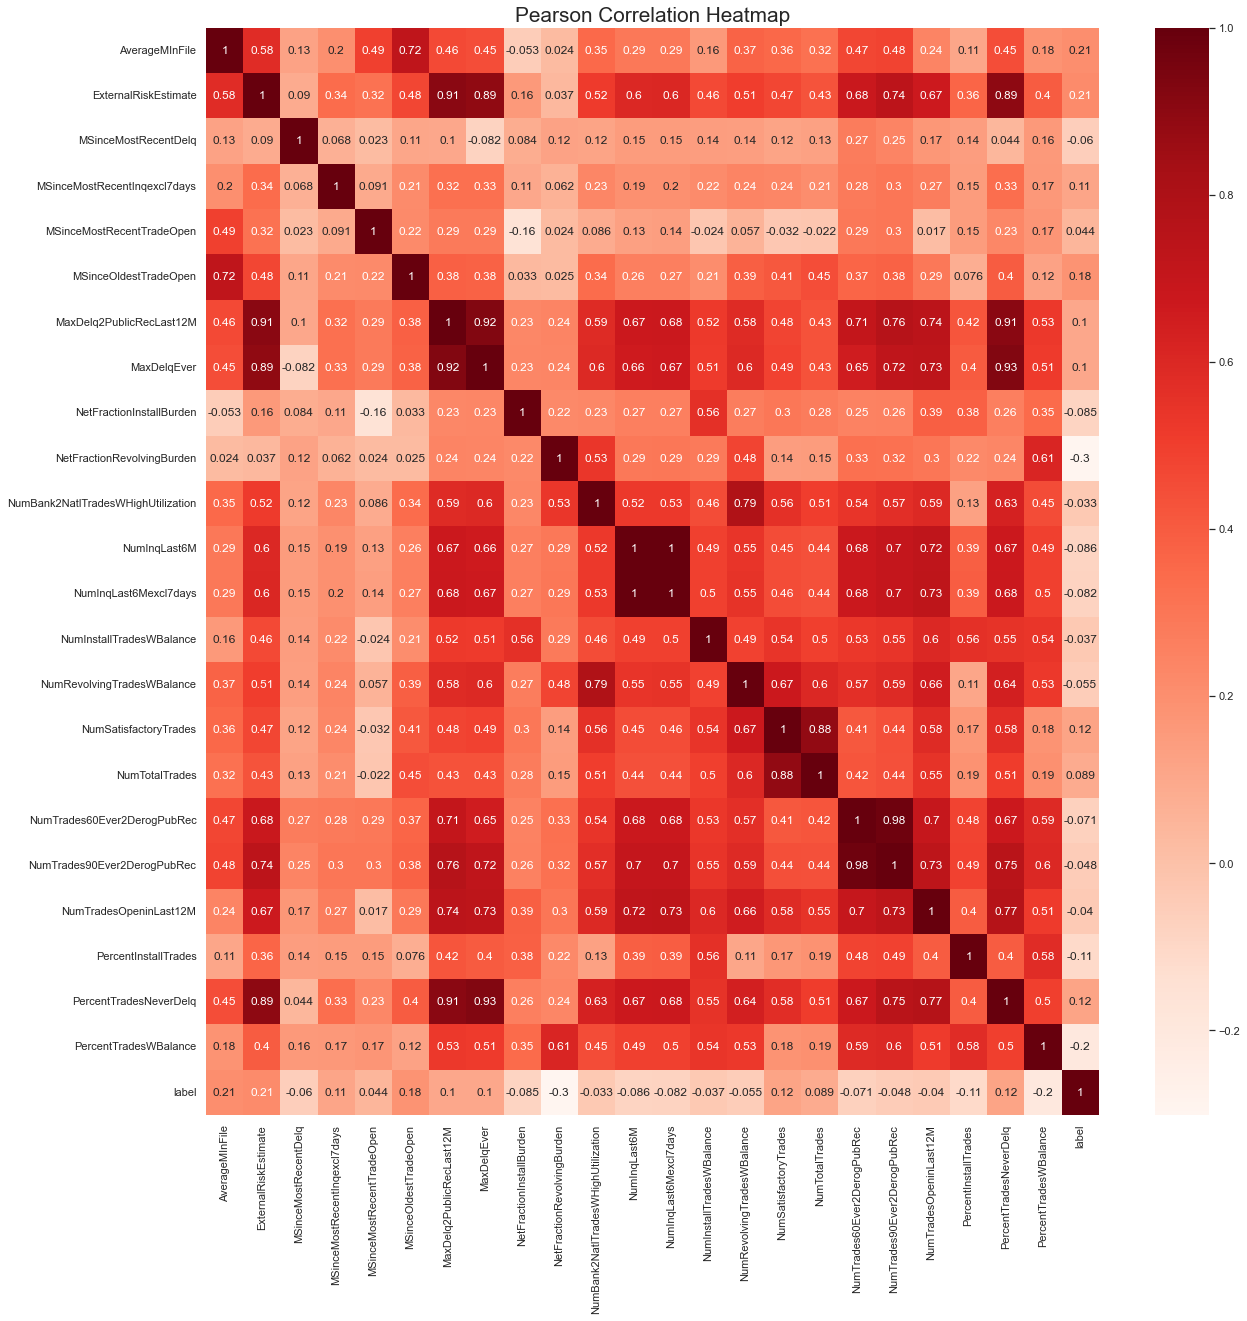

In [144]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title("Pearson Correlation Heatmap", size="xx-large")
sns.heatmap(train.corr(), ax=ax, annot=True, cmap='Reds')

In [58]:
def preprocess(df, return_scaler=True, scaler=None):

    if not return_scaler and scaler is None:
        raise "Please give standard scaler that is fit to the training data."

    if isinstance(df, pd.DataFrame):
        df = df.values

    if scaler is None:
        scaler = StandardScaler()
        df_std = scaler.fit_transform(df)
    
    elif scaler is not None:
        df_std = scaler.transform(df)

    if return_scaler:
        return df_std, scaler
    
    else:
        return df_std

In [61]:
X_train_std, std_scaler = preprocess(X_train, return_scaler=True)
X_dev_std = preprocess(X_dev, return_scaler=False, scaler=std_scaler)

## 4. Modeling

### 4.1 Tree-based Classifiers and TPOT

In [66]:
clf = LGBMClassifier()
clf.fit(X_train, y_train)

print(classification_report(y_dev, clf.predict(X_dev)))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      1228
           1       0.72      0.66      0.69      1126

    accuracy                           0.71      2354
   macro avg       0.71      0.71      0.71      2354
weighted avg       0.71      0.71      0.71      2354



In [65]:
clf = LGBMClassifier()
clf.fit(X_train_std, y_train)

print(classification_report(y_dev, clf.predict(X_dev_std)))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74      1228
           1       0.72      0.67      0.69      1126

    accuracy                           0.71      2354
   macro avg       0.71      0.71      0.71      2354
weighted avg       0.71      0.71      0.71      2354



In [45]:
from sklearn.model_selection import RepeatedStratifiedKFold
from tpot import TPOTClassifier
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search
model = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=1, n_jobs=-1)
# perform the search
model.fit(X_train, y_train)
# export the best model
model.export('tpot_best_model.py')


Generation 1 - Current best internal CV score: 0.7264004580796816

Generation 2 - Current best internal CV score: 0.7271551510524448

Generation 3 - Current best internal CV score: 0.7284780905310108

Generation 4 - Current best internal CV score: 0.7284780905310108

Generation 5 - Current best internal CV score: 0.7284780905310108

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.5, max_depth=1, min_child_weight=20, n_estimators=100, n_jobs=1, subsample=0.9000000000000001, verbosity=0)


In [46]:
model.score(X_dev, y_dev)

0.7153780798640612

In [115]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
# tpot_data = train
# features = tpot_data.drop('label', axis=1)
features = X_train_std
training_features, testing_features, training_target, testing_target = \
            train_test_split(X_train_std, y_train, random_state=1)

# Average CV score on the training set was: 0.7284780905310108
exported_pipeline = XGBClassifier(learning_rate=0.5, max_depth=1, min_child_weight=20, n_estimators=100, n_jobs=1, subsample=0.9000000000000001, verbosity=0)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 1)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [116]:
print(classification_report(testing_target, results))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       933
           1       0.72      0.68      0.70       832

    accuracy                           0.72      1765
   macro avg       0.72      0.72      0.72      1765
weighted avg       0.72      0.72      0.72      1765



In [118]:
preds = exported_pipeline.predict(X_dev_std)
f1_score(y_dev, preds)

0.6894956038870893

<BarContainer object of 23 artists>

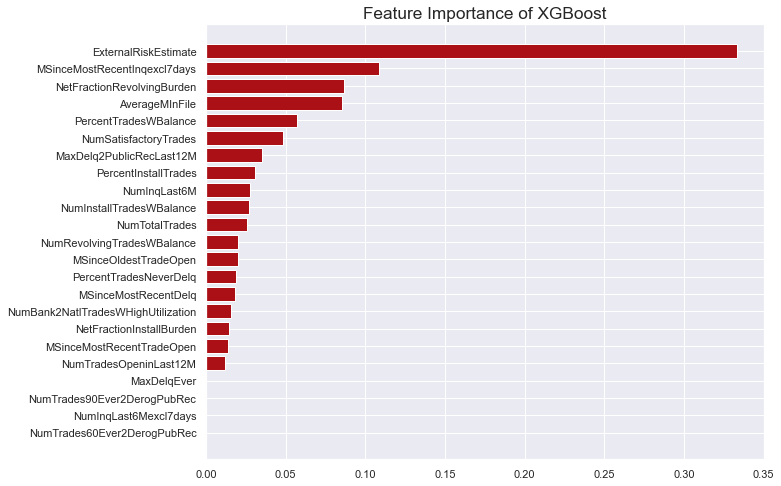

In [140]:
sns.set_theme(palette="Reds_r")
fig, ax = plt.subplots(figsize=(10,8))
sorted_idx = exported_pipeline.feature_importances_.argsort()
ax.set_title("Feature Importance of XGBoost", size="x-large")
ax.barh(X_train.columns[sorted_idx], exported_pipeline.feature_importances_[sorted_idx])

In [152]:
# 10-fold training
kfold = KFold(n_splits=10)

models = []
valid_scores = []
test_scores = []
feature_importances = []
for n, (train_index, test_index) in enumerate(kfold.split(X_train)):

    model = XGBClassifier(
        learning_rate=0.5,
        max_depth=1,
        min_child_weight=20,
        n_estimators=100,
        n_jobs=1,
        subsample=0.9,
        verbosity=0
    )
    model.fit(X_train.values[train_index], y_train.values[train_index])
    print(f"{n}th fold valid score: {f1_score(y_train.values[test_index], model.predict(X_train.values[test_index]))}")
    print(f"{n}th fold hold-out test score: {f1_score(y_dev, model.predict(X_dev))}")
    models.append(model)
    feature_importances.append(model.feature_importances_)

C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0th fold valid score: 0.6912442396313364
0th fold hold-out test score: 0.7011547344110854


C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1th fold valid score: 0.7355623100303952
1th fold hold-out test score: 0.6934071000461042


C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


2th fold valid score: 0.7560240963855421
2th fold hold-out test score: 0.6869806094182825


C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


3th fold valid score: 0.6818873668188736
3th fold hold-out test score: 0.6941230911614993


C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


4th fold valid score: 0.6964560862865947
4th fold hold-out test score: 0.6931608133086875
5th fold valid score: 0.7002967359050445


C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


5th fold hold-out test score: 0.7008784096162737
6th fold valid score: 0.6873065015479877


C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


6th fold hold-out test score: 0.6930510814542108
7th fold valid score: 0.6677367576243982


C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


7th fold hold-out test score: 0.6959334565619224


C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


8th fold valid score: 0.7247706422018348
8th fold hold-out test score: 0.6943674976915973


C:\Users\pha\anaconda3\envs\xai606\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


9th fold valid score: 0.6884272997032641
9th fold hold-out test score: 0.6945337620578779


In [155]:
mean_fi = np.mean(feature_importances, axis=0)
std_fi = np.std(feature_importances, axis=0)

<BarContainer object of 23 artists>

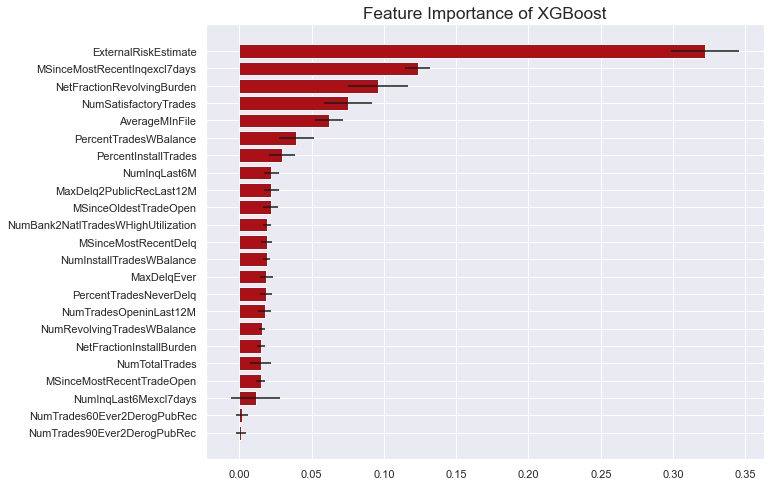

In [159]:
fig, ax = plt.subplots(figsize=(10,8))
sorted_idx = mean_fi.argsort()
ax.set_title("Feature Importance of XGBoost", size="x-large")
plt.barh(X_train.columns[sorted_idx], mean_fi[sorted_idx], xerr=std_fi[sorted_idx])

### 4.2 TabNet

In [29]:
from pytorch_tabnet.tab_model import TabNetClassifier

n_d = 32
n_a = n_d
n_steps = 10
clf = TabNetClassifier(
  n_d=n_d, n_a=n_a, n_steps=n_steps
)  #TabNetRegressor()
clf.fit(
  X_train.to_numpy(), y_train.to_numpy(),
  eval_set=[(X_dev.to_numpy(), y_dev.to_numpy())]
)
# preds = clf.predict(X_test)

Device used : cuda
epoch 0  | loss: 1.09256 | val_0_auc: 0.59277 |  0:00:00s
epoch 1  | loss: 1.01936 | val_0_auc: 0.52239 |  0:00:01s
epoch 2  | loss: 0.86593 | val_0_auc: 0.57217 |  0:00:02s
epoch 3  | loss: 0.80463 | val_0_auc: 0.50484 |  0:00:03s
epoch 4  | loss: 0.75739 | val_0_auc: 0.64364 |  0:00:04s
epoch 5  | loss: 0.65357 | val_0_auc: 0.56556 |  0:00:05s
epoch 6  | loss: 0.64083 | val_0_auc: 0.57154 |  0:00:06s
epoch 7  | loss: 0.63655 | val_0_auc: 0.62179 |  0:00:07s
epoch 8  | loss: 0.6074  | val_0_auc: 0.62459 |  0:00:08s
epoch 9  | loss: 0.62306 | val_0_auc: 0.65933 |  0:00:09s
epoch 10 | loss: 0.60816 | val_0_auc: 0.70067 |  0:00:10s
epoch 11 | loss: 0.58626 | val_0_auc: 0.70453 |  0:00:10s
epoch 12 | loss: 0.64124 | val_0_auc: 0.70309 |  0:00:11s
epoch 13 | loss: 0.67383 | val_0_auc: 0.68372 |  0:00:12s
epoch 14 | loss: 0.62917 | val_0_auc: 0.68705 |  0:00:13s
epoch 15 | loss: 0.61929 | val_0_auc: 0.71853 |  0:00:14s
epoch 16 | loss: 0.6011  | val_0_auc: 0.72558 |  0:00

In [132]:
X_train_numpy = X_train.to_numpy()
y_train_numpy = y_train.to_numpy()
X_dev_numpy = X_dev.to_numpy()
y_dev_numpy = y_dev.to_numpy()

# X_train_numpy = X_train_std
# y_train_numpy = y_train.to_numpy()
# X_dev_numpy = X_dev_std
# y_dev_numpy = y_dev.to_numpy()

In [71]:
results = {}

n_d_lst = [8, 16, 32, 64]
n_steps_lst = [3, 4, 5, 6, 7, 8, 9, 10]

for n_d in n_d_lst:
    n_step_results = []
    for n_steps in n_steps_lst:
        clf = TabNetClassifier(
            n_d=n_d,
            n_a=n_d,
            n_steps=n_steps
        ) 
        clf.fit(
            X_train_numpy, y_train_numpy,
            eval_set=[(X_dev_numpy, y_dev_numpy)]
        )
        preds = clf.predict(X_dev_numpy)
        n_step_results.append((
            f1_score(y_dev_numpy, preds), accuracy_score(y_dev_numpy, preds), roc_auc_score(y_dev_numpy, preds)
        ))
    results[n_d] = n_step_results

Device used : cuda
epoch 0  | loss: 0.78951 | val_0_auc: 0.6363  |  0:00:00s
epoch 1  | loss: 0.67745 | val_0_auc: 0.71133 |  0:00:00s
epoch 2  | loss: 0.6378  | val_0_auc: 0.70831 |  0:00:01s
epoch 3  | loss: 0.61828 | val_0_auc: 0.72949 |  0:00:01s
epoch 4  | loss: 0.60307 | val_0_auc: 0.74162 |  0:00:01s
epoch 5  | loss: 0.58923 | val_0_auc: 0.75073 |  0:00:02s
epoch 6  | loss: 0.5826  | val_0_auc: 0.74632 |  0:00:02s
epoch 7  | loss: 0.57986 | val_0_auc: 0.75873 |  0:00:02s
epoch 8  | loss: 0.57347 | val_0_auc: 0.76798 |  0:00:03s
epoch 9  | loss: 0.56631 | val_0_auc: 0.76884 |  0:00:03s
epoch 10 | loss: 0.56533 | val_0_auc: 0.75824 |  0:00:04s
epoch 11 | loss: 0.56314 | val_0_auc: 0.77019 |  0:00:04s
epoch 12 | loss: 0.56061 | val_0_auc: 0.76852 |  0:00:04s
epoch 13 | loss: 0.56316 | val_0_auc: 0.76655 |  0:00:05s
epoch 14 | loss: 0.56113 | val_0_auc: 0.76949 |  0:00:05s
epoch 15 | loss: 0.55812 | val_0_auc: 0.77437 |  0:00:05s
epoch 16 | loss: 0.55638 | val_0_auc: 0.77342 |  0:00

In [72]:
results

{8: [(0.6856330014224752, 0.7183517417162277, 0.7151847651888152),
  (0.6865808823529411, 0.7102803738317757, 0.7083338154720233),
  (0.6869525126786538, 0.7115548003398471, 0.7094815466237756),
  (0.6964769647696477, 0.7145284621920136, 0.7132906833448082),
  (0.7020443671161375, 0.7090059473237044, 0.7093253336881875),
  (0.7012118679481822, 0.6962616822429907, 0.6982906254881655),
  (0.705349794238683, 0.6958368734069669, 0.6985473643406368),
  (0.6806526806526806, 0.7090059473237044, 0.7064852957342298)],
 16: [(0.6874708896134141, 0.7149532710280374, 0.712480690345462),
  (0.6883891693437356, 0.7115548003398471, 0.7096659646727339),
  (0.6909770920991117, 0.7192013593882752, 0.7165892351930387),
  (0.7147679324894515, 0.7128292268479184, 0.7144651731938602),
  (0.7005300353356891, 0.7119796091758709, 0.7116591260175537),
  (0.6843328684332869, 0.7115548003398471, 0.7091495941356507),
  (0.6732860520094562, 0.7064570943075617, 0.7033783940153089),
  (0.6689221846302562, 0.709005947

In [107]:
import pickle

with open("./assets/tabnet_pp.pkl", "wb") as f:
    pickle.dump(results, f)

In [108]:
with open("./assets/tabnet_wo_pp.pkl", "rb") as f:
    ree = pickle.load(f)

In [109]:
f1_results = [[l[0] for l in lst] for lst in ree.values()]
acc_results = [[l[1] for l in lst] for lst in ree.values()]
# auc_results = [[l[2] for l in lst] for lst in results.values()]

Text(0.5, 1.0, 'F1-score Results for TabNet Result (%)')

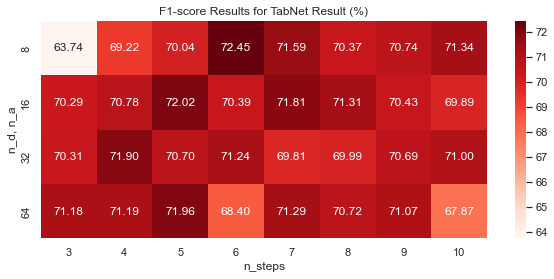

In [166]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))

sns.heatmap(
    pd.DataFrame(f1_results, columns=n_steps_lst, index=n_d_lst) * 100,
    annot=True, ax=ax, fmt=".2f", cmap="Reds")
ax.set_xlabel("n_steps")
ax.set_ylabel("n_d, n_a")
ax.set_title("F1-score Results for TabNet Result (%)")

Text(0.5, 1.0, 'Accuracy Results for TabNet Result (%)')

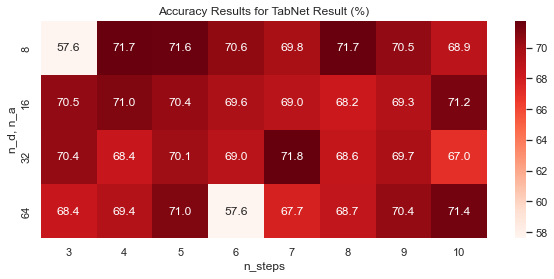

In [141]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.heatmap(
    pd.DataFrame(acc_results, columns=n_steps_lst, index=n_d_lst) * 100,
    annot=True, ax=ax, fmt=".1f", cmap="Reds"
)
ax.set_xlabel("n_steps")
ax.set_ylabel("n_d, n_a")
ax.set_title("Accuracy Results for TabNet Result (%)")

Text(0.5, 1.0, 'AUC Results for TabNet Result (%)')

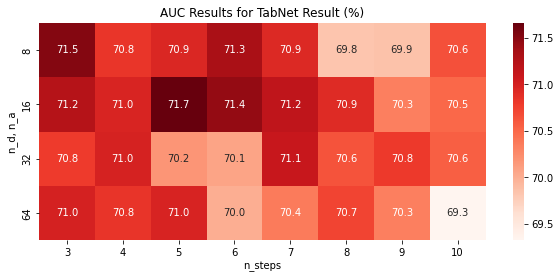

In [114]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.heatmap(
    pd.DataFrame(auc_results, columns=n_steps_lst, index=n_d_lst) * 100,
    annot=True, ax=ax, fmt=".1f", cmap="Reds"
)
ax.set_xlabel("n_steps")
ax.set_ylabel("n_d, n_a")
ax.set_title("AUC Results for TabNet Result (%)")

In [133]:
n_d = 32
n_a = n_d
n_steps = 7
clf = TabNetClassifier(
  n_d=n_d, n_a=n_a, n_steps=n_steps
)  #TabNetRegressor()
clf.fit(
  X_train.to_numpy(), y_train.to_numpy(),
  eval_set=[(X_dev.to_numpy(), y_dev.to_numpy())]
)
# preds = clf.predict(X_test)

Device used : cuda
epoch 0  | loss: 1.58365 | val_0_auc: 0.52538 |  0:00:00s
epoch 1  | loss: 0.894   | val_0_auc: 0.55196 |  0:00:01s
epoch 2  | loss: 0.80068 | val_0_auc: 0.55237 |  0:00:02s
epoch 3  | loss: 0.71443 | val_0_auc: 0.57325 |  0:00:02s
epoch 4  | loss: 0.65646 | val_0_auc: 0.50477 |  0:00:03s
epoch 5  | loss: 0.63259 | val_0_auc: 0.61151 |  0:00:04s
epoch 6  | loss: 0.64533 | val_0_auc: 0.64146 |  0:00:04s
epoch 7  | loss: 0.62093 | val_0_auc: 0.62096 |  0:00:05s
epoch 8  | loss: 0.64406 | val_0_auc: 0.61167 |  0:00:06s
epoch 9  | loss: 0.62514 | val_0_auc: 0.61793 |  0:00:06s
epoch 10 | loss: 0.59547 | val_0_auc: 0.63045 |  0:00:07s
epoch 11 | loss: 0.59937 | val_0_auc: 0.63586 |  0:00:08s
epoch 12 | loss: 0.59028 | val_0_auc: 0.65463 |  0:00:08s
epoch 13 | loss: 0.57964 | val_0_auc: 0.66033 |  0:00:09s
epoch 14 | loss: 0.57443 | val_0_auc: 0.65426 |  0:00:10s
epoch 15 | loss: 0.578   | val_0_auc: 0.68494 |  0:00:10s
epoch 16 | loss: 0.58049 | val_0_auc: 0.70179 |  0:00

In [134]:
explain_matrix, masks = clf.explain(X_dev_numpy)

In [177]:
exp = explain_matrix.mean(axis=0)



array([1.20863188e+00, 3.27713632e+00, 6.23675768e-01, 2.24156299e+00,
       6.36600747e-02, 1.23139502e+00, 1.14922274e-02, 5.84300591e-01,
       4.67909567e-01, 1.65621567e+00, 2.37812975e-01, 2.91280643e-01,
       4.27534888e-01, 4.61423237e-01, 9.09041504e-04, 2.85859831e-01,
       6.81917290e-01, 3.63279452e-01, 3.97185012e-02, 1.06079546e+00,
       1.17205818e+00, 8.71272445e-01, 1.09105605e+00])

In [171]:
len(masks)

7

<BarContainer object of 23 artists>

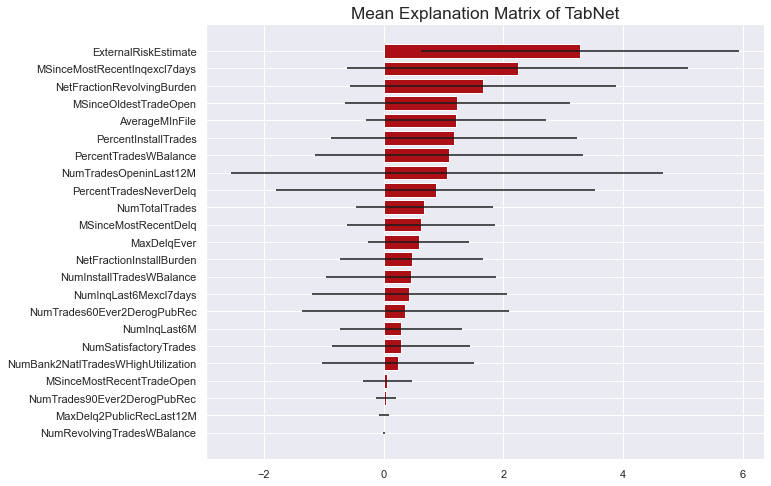

In [180]:
fig, ax = plt.subplots(figsize=(10,8))

exp = explain_matrix.mean(axis=0)
exp_std = explain_matrix.std(axis=0)
sorted_idx = exp.argsort()
ax.set_title("Mean Explanation Matrix of TabNet", size="x-large")
plt.barh(X_train.columns[sorted_idx], exp[sorted_idx], xerr=exp_std[sorted_idx])

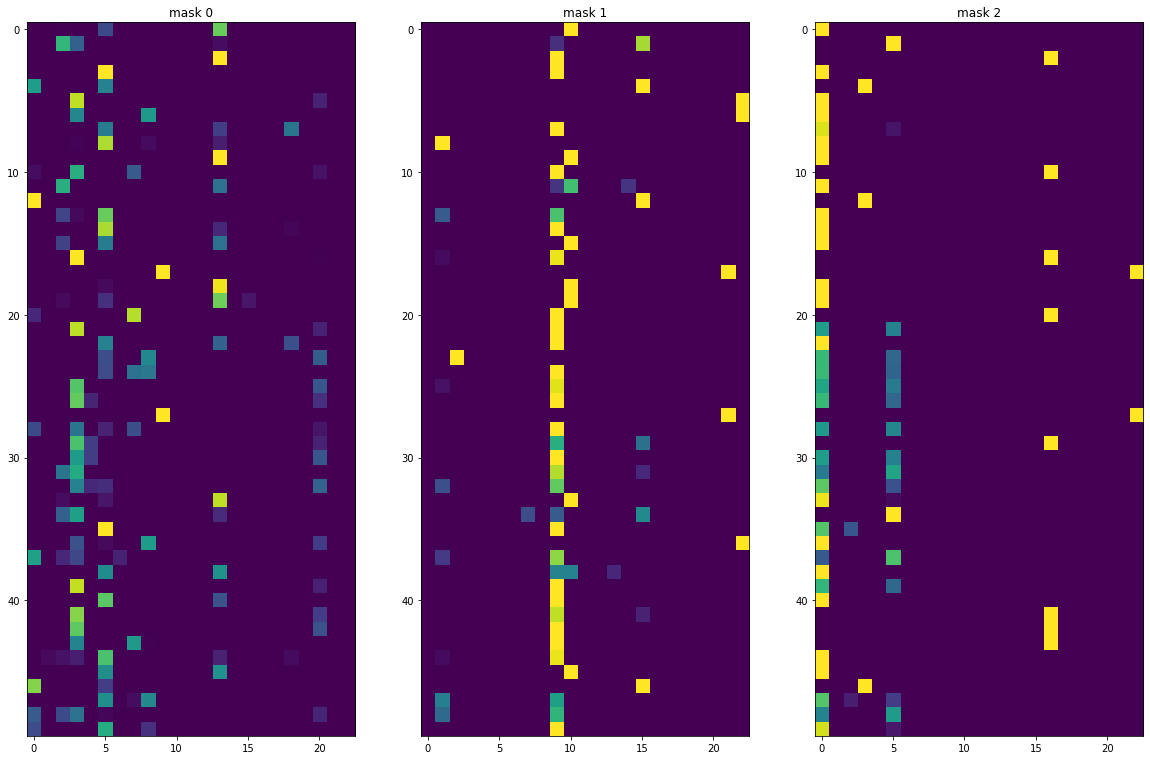

In [135]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [136]:
clf.feature_importances_

array([6.73389684e-02, 1.75803600e-01, 3.21309615e-02, 1.30200627e-01,
       3.73508281e-03, 6.67543329e-02, 8.75245263e-04, 3.07108725e-02,
       2.53770301e-02, 9.04753762e-02, 1.18007614e-02, 1.57199594e-02,
       2.79633449e-02, 2.60848009e-02, 2.77657214e-05, 1.55240485e-02,
       3.85518491e-02, 1.98319396e-02, 2.45383711e-03, 5.27169235e-02,
       6.50879214e-02, 4.47634745e-02, 5.60712774e-02])

<BarContainer object of 23 artists>

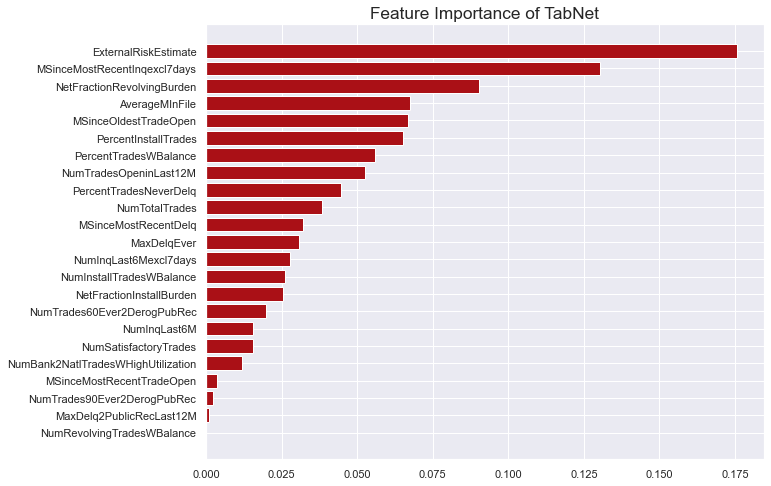

In [164]:
fig, ax = plt.subplots(figsize=(10,8))
sorted_idx = clf.feature_importances_.argsort()
ax.set_title("Feature Importance of TabNet", size="x-large")
plt.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])